# Projet Data Science - Simulateur de DPE
## ENSAE Paris - 2A

Membres du groupe : 
- Wiam LACHQER , Amine RAZIG , Julien BOUDIER

Ce projet Python a été créé dans le but de fournir des visualisations variées des données et de mettre en place un simulateur de Diagnostic de Performance Energétique (DPE) à partir de la base de données de l'ADEME (Agence de la Transition Écologique).

## Objectifs du Projet

1. **Visualisations de Données :** Le projet propose différentes visualisations des données issues de la base de l'ADEME. Ces visualisations permettent une compréhension approfondie des caractéristiques énergétiques des logements.

2. **Simulateur de DPE :** Un simulateur de DPE a été développé en utilisant les données de l'ADEME. Ce simulateur permet d'estimer la performance énergétique d'un logement en fonction de divers paramètres.\

Ce simulateur fournit une estimation de la consommation énergétique et du volume des émissions de gaz à effet de serre par an et par m² en se basant sur les caractéristiques du logement. La base de données disponible sur le site contient 244 colonnes, on est amenés à choisir une trentaine de variables pour minimiser le coût de la modélisation. 
Pour ce faire, on s’est inspirés des simulateurs disponibles en ligne (comme celui-ci https://diagnosticdpe.com/estimer-DPE.php), les informations demandées doivent être accessibles pour le propriétaire. Certaines colonnes sont supprimées puisque le nombre de leurs valeurs manquantes est très élevé, ce qui n’est pas pratique pour la modélisation.


 Pour plus de détail sur l’étiquette DPE: https://www.choisir.com/energie/articles/199743/tout-savoir-sur-le-calcul-du-dpe

## Importation des librairies

In [233]:
import fetchdata
import eda

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, MultiTaskLassoCV

from sklearn.preprocessing import StandardScaler

from sklearn import linear_model
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, r2_score, accuracy_score, ConfusionMatrixDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline




# Détection des valeurs manquantes et data pre-processing

La base de données contient plusieurs colonnes qu’on peut utiliser comme variables pour prédire la consommation de l’énergie par m², un nettoyage et un encodage de données sont alors nécessaires pour pouvoir sélectionner les colones à utiliser et avoir des données intérprétables par les modèles de machine learning (régression linéaire, XGBoost, CATBoost).

Le plan de ce qui suit:
- Importation des données.
- Suppression des colonnes dont plus de 60% de leurs valeurs sont manquantes.
- Analyse des corrélations entre les variables continues et de leurs distribution.
- Traitement des valeurs aberrantes 
- Visualisation et encodage des variables catégorielles
- Utilisation de la régularisation de Lasso pour sélectionner les variables explicatives les plus significatives

## Importation des données

In [292]:

chosen_variables=['Type_énergie_n°1',
                  'Type_énergie_n°2',
                  'Type_énergie_n°3',
                  'Etiquette_GES',
                  'Etiquette_DPE',
                  #'Année_construction',
                  'Type_bâtiment',
                  'Période_construction',
                  'Hauteur_sous-plafond',
                  'Surface_habitable_logement',
                  'Classe_altitude',
                  'Zone_climatique_',
                  #'Nom__commune_(BAN)',
                  #'Coordonnée_cartographique_X_(BAN)',     
                  #'Coordonnée_cartographique_Y_(BAN)',
                  #'N°_région_(BAN)',
                  'Conso_5_usages_é_finale',
                  'Conso_5_usages/m²_é_finale',
                  'Conso_chauffage_é_finale',
                  'Emission_GES_5_usages',
                  'Emission_GES_5_usages_par_m²',
                  'Conso_5_usages_é_finale_énergie_n°1',
                  #'Coût_total_5_usages_énergie_n°1',
                  'Conso_5_usages_é_finale_énergie_n°2',
                  'Coût_total_5_usages_énergie_n°2',
                  'Conso_5_usages_é_finale_énergie_n°3',
                  #'Coût_total_5_usages_énergie_n°3',
                  'Coût_total_5_usages',
                  'Qualité_isolation_enveloppe',
                  'Qualité_isolation_menuiseries',
                  'Qualité_isolation_murs',
                  'Qualité_isolation_plancher_bas',
                  'Type_énergie_principale_chauffage',
                  'Type_installation_ECS',
                  'Type_installation_solaire',
                  'Surface_climatisée',               
                  'Type_ventilation',
                  'Protection_solaire_exterieure_(0/1)',
                  'Isolation_toiture_(0/1)',
                  'Indicateur_confort_été']

df1 = fetchdata.get_dpe(chosen_variables, size =150000)

Fetched 10000 observations
Fetched 20000 observations
Fetched 30000 observations
Fetched 40000 observations
Fetched 50000 observations
Fetched 60000 observations
Fetched 70000 observations
Fetched 80000 observations
Fetched 90000 observations
Fetched 100000 observations
Fetched 110000 observations
Fetched 120000 observations
Fetched 130000 observations
Fetched 140000 observations
Fetched 150000 observations


In [293]:
df1 = df1.drop_duplicates()

In [294]:
eda.create_unique(df1)

,Column_name,Data_type,Number_of_unique,Number_of_missing,Unique_values,Rate_of_missing
0,Type_énergie_n°3,object,12,121586,"[Électricité, nan, Bois – Bûches, GPL, Gaz nat...",0.949097
0,Type_énergie_n°1,object,12,0,"[Réseau de Chauffage urbain, Électricité, Fiou...",0.000000
0,Emission_GES_5_usages_par_m²,float64,1241,121,More than 15 unique values,0.000945
0,Coût_total_5_usages_énergie_n°2,float64,20510,51385,More than 15 unique values,0.401110
0,Conso_5_usages_é_finale,float64,96603,122,More than 15 unique values,0.000952
0,Type_énergie_n°2,object,13,51385,"[Gaz naturel, Réseau de Chauffage urbain, Bois...",0.401110
0,Qualité_isolation_enveloppe,object,4,0,"[insuffisante, bonne, moyenne, très bonne]",0.000000
0,Coût_total_5_usages,float64,28157,122,More than 15 unique values,0.000952
0,Emission_GES_5_usages,float64,45457,121,More than 15 unique values,0.000945
0,Qualité_isolation_plancher_bas,object,4,1888,"[insuffisante, très bonne, moyenne, bonne, nan]",0.014738


On supprime "Surface_climatisée, Type_installation_solaire, _score, Conso_5_usages_é_finale_énergie_n°3,Coût_total_5_usages_énergie_n°3, Type_énergie_n°3, Protection_solaire_exterieure_(0/1), Isolation_toiture_(0/1), Indicateur_confort_été" puisque le nombre de valeurs manquantes dans chacune de ces colonnes dépasse 60% du nombre d’observations.\
La variable "type_ventilation" contient un nombre assez élevé de valeurs manquantes(0,31), mais on l’utilisera pour la prédiction puisque c’est une variable pertinente.

In [295]:
# Suppression des colonnes 

cols_to_drop = ["Surface_climatisée", 
                "Type_installation_solaire", 
                "_score", 
                "Conso_5_usages_é_finale_énergie_n°3",
                "Type_énergie_n°3",
                "Type_ventilation",
                "Conso_5_usages_é_finale_énergie_n°2",
                'Protection_solaire_exterieure_(0/1)',
                'Isolation_toiture_(0/1)',
                'Indicateur_confort_été'
                ]

df = df1.drop(cols_to_drop, axis=1, inplace=False)

In [296]:
# Suppression des lignes avec des valeurs manquantes

df = df.dropna(axis=0, how='any')

In [297]:
df.shape

(74131, 24)

La base de données qu’on a retenue contient 74131 observations, elle est donc suffisante pour entrainer et tester le modèle.

## Exploration des variables continues

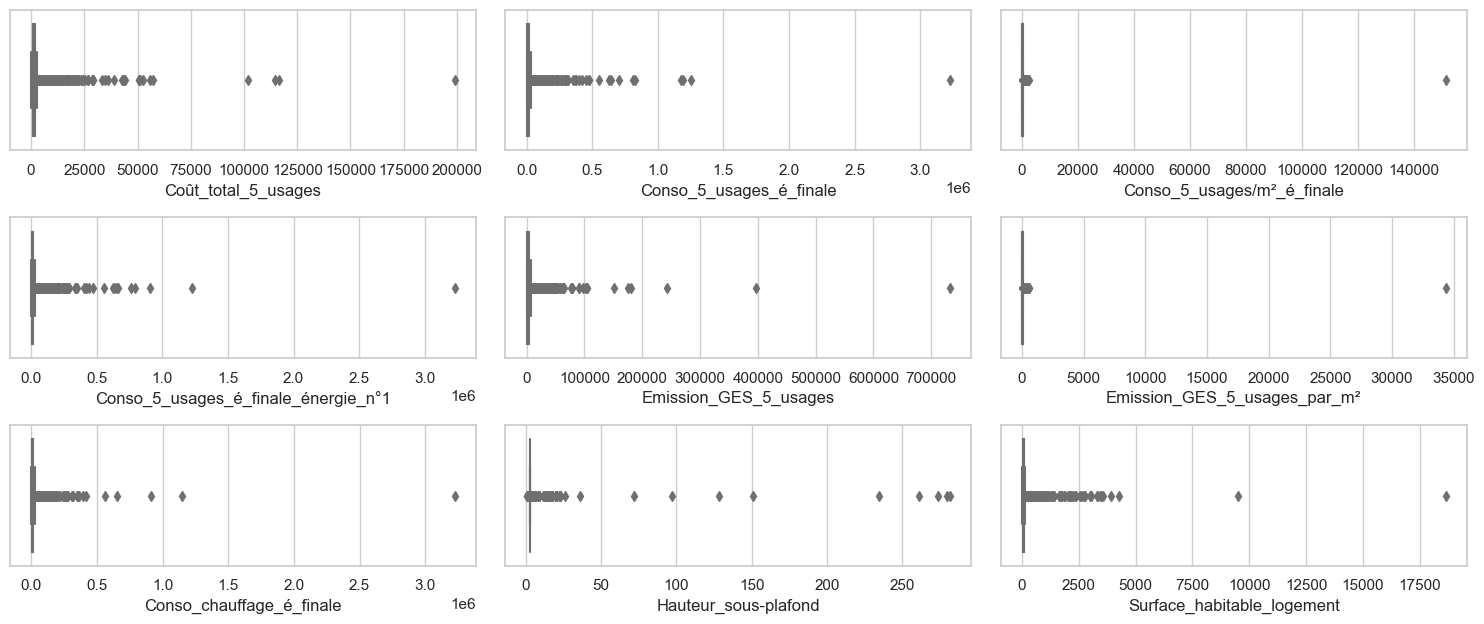

In [298]:
continuous_variables =['Coût_total_5_usages','Conso_5_usages_é_finale','Conso_5_usages/m²_é_finale','Conso_5_usages_é_finale_énergie_n°1', 'Emission_GES_5_usages','Emission_GES_5_usages_par_m²','Conso_chauffage_é_finale','Hauteur_sous-plafond','Surface_habitable_logement']

eda.boxplot(df,continuous_variables)

On remarque que toutes les variables contiennent des valeurs aberrantes très élevées par rapport aux autres valeurs, cela risque d’impacter la modélisation, mais on ne va pas les supprimer puisqu’il s’agit bien des logements existants, et leur suppression conduit à une sous-estimation de la consommation de la consommation et du volume des émissions dans certains logements. On va alors remplacer les valeurs très élevées par (q3 + 3.5 * iqr) et les valeurs très faibles par (q3 - 3.5 * iqr) avec q1 et q3 sont le premier et le troisième quantile, et iqr est la différence entre les deux.

In [299]:
# Détection du nombre des valeurs aberrantes par la méthode des quantiles

eda.Outliers(df,continuous_variables)

,variable,nombre_val_aberrantes
0,Coût_total_5_usages,1049
0,Conso_5_usages_é_finale,1035
0,Conso_5_usages/m²_é_finale,185
0,Conso_5_usages_é_finale_énergie_n°1,1000
0,Emission_GES_5_usages,1341
0,Emission_GES_5_usages_par_m²,198
0,Conso_chauffage_é_finale,1061
0,Hauteur_sous-plafond,16040
0,Surface_habitable_logement,1212


In [300]:
df["Hauteur_sous-plafond"].describe()

count    74131.000000
mean         2.579729
std          2.381128
min          0.400000
25%          2.500000
50%          2.500000
75%          2.500000
max        282.000000
Name: Hauteur_sous-plafond, dtype: float64

In [301]:
df = eda.remplacer_outliers(df,continuous_variables)

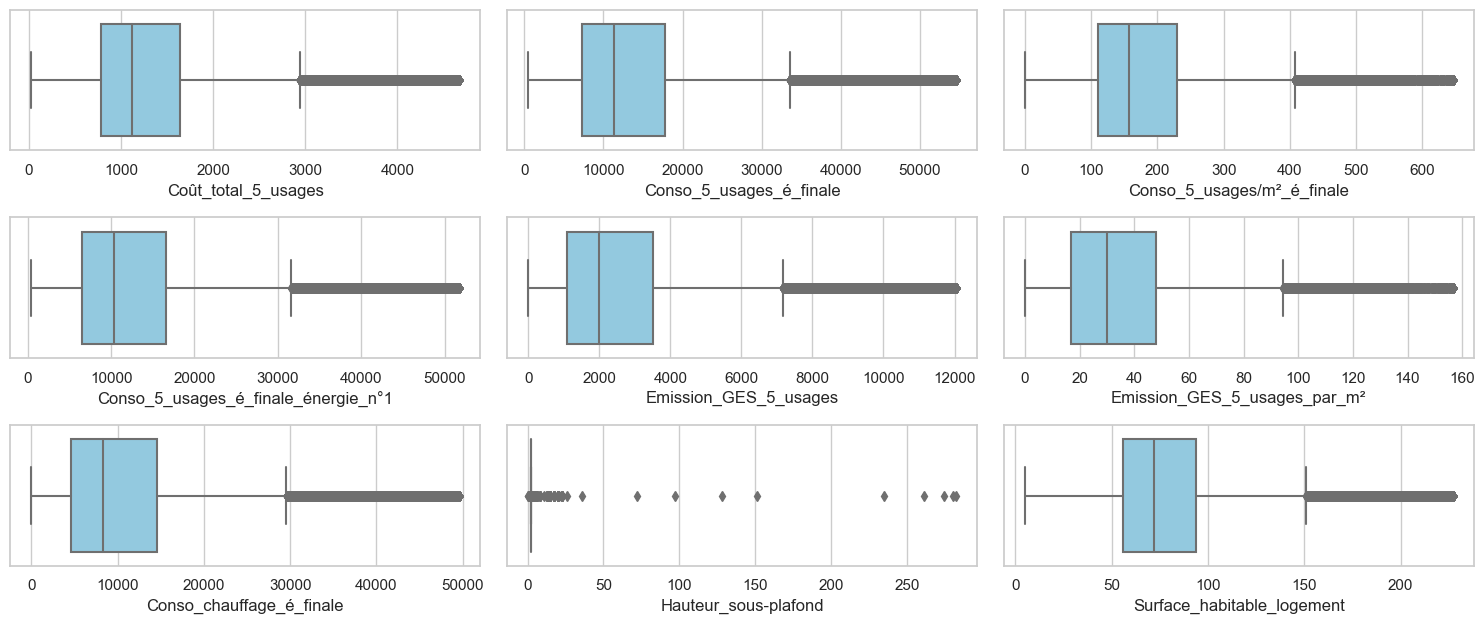

In [302]:
eda.boxplot(df,continuous_variables)

On choisit de prédire directement la consommation de l’énergie et le volume des émissions par m² puisque ces deux variables contiennent le minimum de valeurs aberrantes. Les variables explicatives continues sont la surface du logement, la hauteur sous plafond et le coût de la consommation totale de l’énergie.

In [303]:
# Standardisation des variables  explicatives continues

scaler = StandardScaler()
continuous_explicative = ["Surface_habitable_logement","Hauteur_sous-plafond" ,'Coût_total_5_usages']
df[continuous_explicative] = scaler.fit_transform(df[continuous_explicative])

In [304]:
# Corrélation entre les variables continues 

corr = df.loc[:,["Surface_habitable_logement","Hauteur_sous-plafond","Conso_5_usages/m²_é_finale","Emission_GES_5_usages_par_m²",'Coût_total_5_usages']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Surface_habitable_logement,Hauteur_sous-plafond,Conso_5_usages/m²_é_finale,Emission_GES_5_usages_par_m²,Coût_total_5_usages
Surface_habitable_logement,1.000000,0.016636,-0.070053,-0.098619,0.684730
Hauteur_sous-plafond,0.016636,1.000000,0.024327,0.027579,0.030062
Conso_5_usages/m²_é_finale,-0.070053,0.024327,1.000000,0.837521,0.516882
Emission_GES_5_usages_par_m²,-0.098619,0.027579,0.837521,1.000000,0.465032
Coût_total_5_usages,0.684730,0.030062,0.516882,0.465032,1.000000


On remarque une forte corrélation positive entre la consommation énergétique et le volume des émissions de gaz à effet de serre.
Ces deux variables ont les mêmes corrélations avec les variables explicatives retenus. Nous pouvons envisager de prédire l’une à partir de l’autre.\
La variable Hauteur_sous_plafond est peu corrélées avec les variables cibles, en plus, le traitement de ses valeurs aberrantes nous pose un problème, on va alors l’exclure de la prédiction.

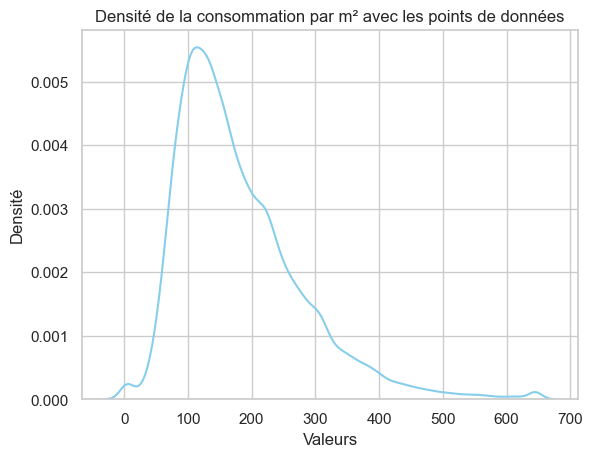

279.45


In [305]:

sns.set(style="whitegrid")
sns.kdeplot(df["Conso_5_usages/m²_é_finale"], color="skyblue")
plt.title('Densité de la consommation par m² avec les points de données')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.show()

print(df["Conso_5_usages/m²_é_finale"].max()-df["Conso_5_usages/m²_é_finale"].quantile(0.95))

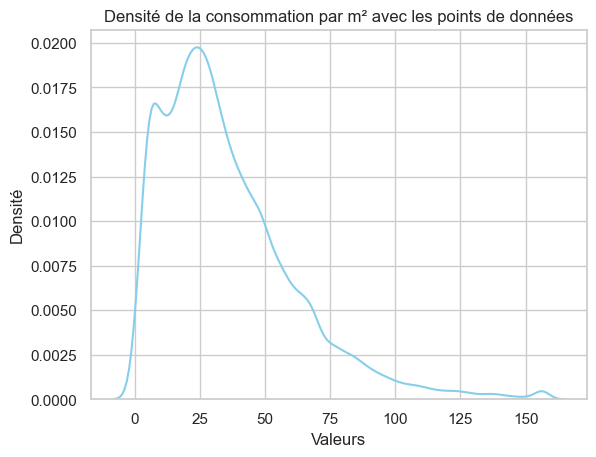

71.5


In [306]:
sns.set(style="whitegrid")
sns.kdeplot(df["Emission_GES_5_usages_par_m²"], color="skyblue")
plt.title('Densité de la consommation par m² avec les points de données')
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.show()

print(df["Emission_GES_5_usages_par_m²"].max()-df["Emission_GES_5_usages_par_m²"].quantile(0.95))

On remarque que la différence entre le 0.95 quantile et la valeur maximale prise par chaque variable est très élevée (279 pour la consommation et 71.5 pour le volume des émissions), les valeurs qui tombent dans cet intervalle risquent d’tre mal prédites par les modèles. 

## Variables catégorielles

In [307]:
categorical_variables = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Etiquette_GES',
                  'Etiquette_DPE',                 # 7 valeurs uniques
                  'Type_bâtiment',                 # 3 valeurs uniques
                  'Période_construction',          # 10 valeurs uniques
                  'Classe_altitude',               # 3 valeurs uniques
                  'Zone_climatique_',              # 8 valeurs uniques 
                  'Qualité_isolation_enveloppe',    # 4 valeurs uniques 
                  'Qualité_isolation_menuiseries',  # 4 valeurs uniques 
                  'Qualité_isolation_murs',         # 4 valeurs uniques 
                  'Qualité_isolation_plancher_bas', # 4 valeurs uniques 
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                  'Type_installation_ECS',           # 3 valeurs uniques
                  ]      

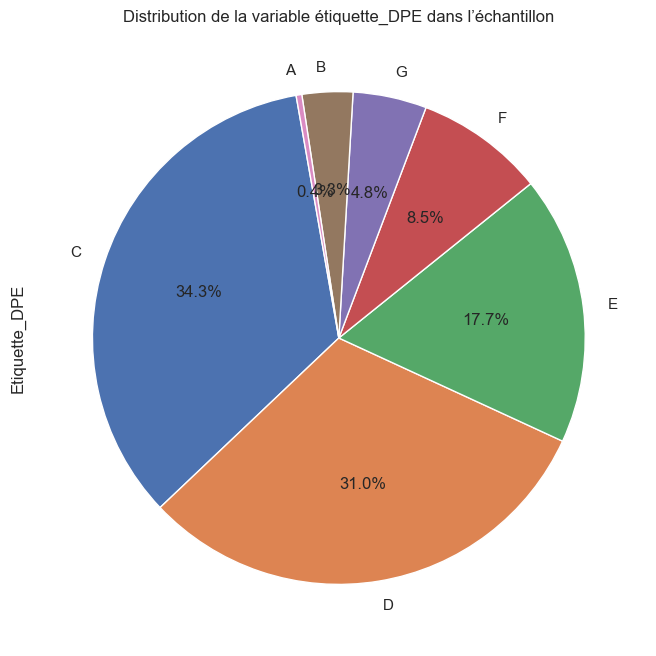

In [308]:
# Distribution des étiquettes DPE 

occurences = df['Etiquette_DPE'].value_counts()

plt.figure(figsize=(8,8))
occurences.plot.pie(autopct='%1.1f%%', startangle=100)
plt.title("Distribution de la variable étiquette_DPE dans l’échantillon")
plt.show()


Les étiquettes A, B et G sont sous-représentées dans l’échantillon, les valeurs de la consommation et le volume des émissions qui leur sont associées risquent d’être mal predites par le modèle, par contre, on s’attend à une bonne prédiction des étiquettes D, E et C.

On explore en détail les variables qui prennent plusieurs valeurs uniques, cela nous aide à trouver un moyen pour les encoder et réduire la complexité du modèle.

In [309]:
categorical_variables1 = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                    ]

In [310]:
df['Type_énergie_n°2'].value_counts()

Électricité                                                     56152
Gaz naturel                                                      8136
Bois – Bûches                                                    5553
Fioul domestique                                                 1366
Bois – Granulés (pellets) ou briquettes                          1062
Réseau de Chauffage urbain                                        861
Électricité d'origine renouvelable utilisée dans le bâtiment      651
GPL                                                               324
Bois – Plaquettes forestières                                      11
Charbon                                                             8
Propane                                                             3
Butane                                                              3
Bois – Plaquettes d’industrie                                       1
Name: Type_énergie_n°2, dtype: int64

In [311]:
# Encodage de la variable 'Type_énergie_n°2'

df['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes'], 'Bois')

df['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain'], 'Énergies propres')

df['Type_énergie_n°2'] = df['Type_énergie_n°2'].replace(["Fioul domestique",'GPL'], 'Énergies polluantes')


On remarque que certaines sources d’énergie sont surreprésentées (Electricité, Bois – Bûches  et Gaz naturel), nous allons donc garder ces trois catégories, et on créera deux autres catégories: la première contient le Fioul Domestique et le GPL comme étant les sources les plus polluantes, et la deuxième regroupe l’électricité d’origine renouvelable et le réseau de chauffage urbain. Nous allons faire de meme avec le type d’énergie 1 et l’énergie utilisée pour le chauffage.

In [312]:
df['Type_énergie_n°1'].value_counts()

Gaz naturel                                                     38743
Électricité                                                     13898
Réseau de Chauffage urbain                                      10026
Fioul domestique                                                 4056
Bois – Bûches                                                    3079
GPL                                                              3021
Bois – Granulés (pellets) ou briquettes                           985
Électricité d'origine renouvelable utilisée dans le bâtiment      150
Bois – Plaquettes forestières                                      69
Bois – Plaquettes d’industrie                                      60
Charbon                                                            29
Propane                                                            15
Name: Type_énergie_n°1, dtype: int64

In [313]:
# Encodage de la variable 'Type_énergie_n°1'

df['Type_énergie_n°1'] = df['Type_énergie_n°1'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

df['Type_énergie_n°1'] = df['Type_énergie_n°1'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain'], 'Énergies propres')

df['Type_énergie_n°1'] = df['Type_énergie_n°1'].replace(["Fioul domestique",'GPL','Propane'], 'Énergies polluantes')

In [314]:
df['Type_énergie_principale_chauffage'].value_counts()

Gaz naturel                                                     43880
Réseau de Chauffage urbain                                      10822
Électricité                                                      7670
Fioul domestique                                                 5260
GPL                                                              3089
Bois – Bûches                                                    2220
Bois – Granulés (pellets) ou briquettes                           943
Bois – Plaquettes forestières                                      69
Bois – Plaquettes d’industrie                                      60
Propane                                                            51
Électricité d'origine renouvelable utilisée dans le bâtiment       35
Charbon                                                            32
Name: Type_énergie_principale_chauffage, dtype: int64

In [315]:
# Encodage de la variable 'Type_énergie_principale_chauffage'

df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(['Bois – Bûches','Bois – Granulés (pellets) ou briquettes', 'Bois – Plaquettes d’industrie', 'Bois – Plaquettes forestières'], 'Bois')

df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(["Fioul domestique",'GPL','Propane'], 'Énergies polluantes')

df['Type_énergie_principale_chauffage'] = df['Type_énergie_principale_chauffage'].replace(["Électricité d'origine renouvelable utilisée dans le bâtiment",'Réseau de Chauffage urbain'], 'Énergies propres')

In [316]:
## Ajouter les visualisations de Amine

### Encodage ordinal pour les variables représentant une hiérarchie naturelle entre les différentes valeurs
Pour les qualités d’isolation, on crée une variable qui prend 0 si l’isolation est insuffisante et 3 si elle est très bonne.\
Pour la période de construction aussi, on crée une variable qui prend les valeurs entre 0 et 9, plus le logement est récent, plus le chiffre est élevé.

In [317]:
df["Période_construction"] = df["Période_construction"].map({"avant 1948":0, "1948-1974":1, "1975-1977":2, "1983-1988":3, '2013-2021':4,'1989-2000':5, '2001-2005':6, '2006-2012':7, '1978-1982':8, 'après 2021':9})

df['Qualité_isolation_plancher_bas'] = df["Qualité_isolation_plancher_bas"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df["Qualité_isolation_murs"] = df["Qualité_isolation_murs"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df['Qualité_isolation_enveloppe'] = df["Qualité_isolation_enveloppe"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})

df["Qualité_isolation_menuiseries"] = df["Qualité_isolation_menuiseries"].map({"très bonne":3, "insuffisante":0, "bonne":2, "moyenne":1})


In [318]:
categorical_variables2 = ['Type_énergie_n°1',       # 11 valeurs uniques
                  'Type_énergie_n°2',              # 8 valeurs uniques
                  'Type_bâtiment',                 # 3 valeurs uniques
                  'Classe_altitude',               # 3 valeurs uniques
                  'Zone_climatique_',              # 8 valeurs uniques  
                  'Type_énergie_principale_chauffage', # 11 valeurs uniques
                  'Type_installation_ECS']           # 3 valeurs uniques

onehotencoded = eda.one_hot_encode(df,categorical_variables2)

Maintenant, on récupère la base de données finale qu’on va utiliser pour la prédiction.

In [319]:
variables_retenues = ['Période_construction',
                  #'Hauteur_sous-plafond',
                  'Surface_habitable_logement',
                  'Conso_5_usages/m²_é_finale',
                  'Emission_GES_5_usages_par_m²',
                  'Qualité_isolation_enveloppe',
                  'Qualité_isolation_menuiseries',
                  'Qualité_isolation_murs',
                  'Qualité_isolation_plancher_bas',
                  'Type_énergie_n°1_Gaz naturel',
                  'Type_énergie_n°1_Électricité', 
                  'Type_énergie_n°1_Énergies polluantes',
                  'Type_énergie_n°1_Énergies propres', 
                  'Type_énergie_n°2_Gaz naturel',
                  'Type_énergie_n°2_Électricité', 
                  'Type_énergie_n°2_Énergies polluantes',
                   'Type_énergie_n°2_Énergies propres', 
                   #'Type_bâtiment_immeuble',
                   'Type_bâtiment_maison', 
                   'Classe_altitude_inférieur à 400m',
                   'Classe_altitude_supérieur à 800m', 
                   'Zone_climatique__H1b',
                   'Zone_climatique__H1c', 
                   'Zone_climatique__H2a', 
                   'Zone_climatique__H2b',
                   'Zone_climatique__H2c', 
                   'Zone_climatique__H2d', 
                   'Zone_climatique__H3',
                    'Type_énergie_principale_chauffage_Gaz naturel',
                   'Type_énergie_principale_chauffage_Électricité',
                    'Type_énergie_principale_chauffage_Énergies polluantes',
                    'Type_énergie_principale_chauffage_Énergies propres',
                    'Type_installation_ECS_installation collective multi-bâtiment : modélisée comme un réseau de chaleur',
                    'Type_installation_ECS_installation individuelle',
                    'Coût_total_5_usages']

df_finale = onehotencoded.loc[:,variables_retenues]
df_finale.columns

Index(['Période_construction', 'Surface_habitable_logement',
       'Conso_5_usages/m²_é_finale', 'Emission_GES_5_usages_par_m²',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres', 'Type_énergie_n°2_Gaz naturel',
       'Type_énergie_n°2_Électricité', 'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m', 'Classe_altitude_supérieur à 800m',
       'Zone_climatique__H1b', 'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c', 'Zone_climatique__H2d',
       'Zone_climatique__H3', 'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergi

In [320]:
df_finale.shape

(74131, 33)

In [321]:
df_finale.columns

Index(['Période_construction', 'Surface_habitable_logement',
       'Conso_5_usages/m²_é_finale', 'Emission_GES_5_usages_par_m²',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres', 'Type_énergie_n°2_Gaz naturel',
       'Type_énergie_n°2_Électricité', 'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m', 'Classe_altitude_supérieur à 800m',
       'Zone_climatique__H1b', 'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c', 'Zone_climatique__H2d',
       'Zone_climatique__H3', 'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergi

In [322]:
df_finale.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 74131 entries, 1 to 149986
Data columns (total 33 columns):
 #   Column                                                                                               Non-Null Count  Dtype  
---  ------                                                                                               --------------  -----  
 0   Période_construction                                                                                 74131 non-null  int64  
 1   Surface_habitable_logement                                                                           74131 non-null  float64
 2   Conso_5_usages/m²_é_finale                                                                           74131 non-null  float64
 3   Emission_GES_5_usages_par_m²                                                                         74131 non-null  float64
 4   Qualité_isolation_enveloppe                                                                          7413

In [323]:
#df_finale = eda.remove_outliers(df_finale)
# jointure de df finale et etiquette colonne
#df_finale = pd.merge(df_finale, df["Etiquette_DPE"],  left_index=True, right_index=True)

# Modélisation

Dans ce qui suit, notre objectif est d’attribuer une étiquette DPE au logement en se basant sur ses caractéristaiques. On va d’abord estimer la consommation de l’énergie à partir des différentes variables traitées avant, ensuite, on utilisera les valeurs obtenues pour estimer le volume des émissions des gaz à effet de serre. Finalement, on va déterminer l’étiquette DPE en fonction des valeurs obtenues, la méthode de classification est résumée dans le tableau suivant:



<img src="img.png"  width="1000" height="600">


In [324]:
def remplissage (row):
    
    if row["conso_predite_s"]<70 and row["emission_predite_s"]<6 :
        return "A"
    elif row["conso_predite_s"]<110 and row["emission_predite_s"]<11 :
        return "B"
    elif row["conso_predite_s"]<180 and row["emission_predite_s"]<30 :
        return "C"
    elif row["conso_predite_s"]<250 and row["emission_predite_s"]<50 :
        return "D"
    elif row["conso_predite_s"]<330 and row["emission_predite_s"]<70 :
        return "E"
    elif row["conso_predite_s"]<420 and row["emission_predite_s"]<100 :
        return "F"
    else:
        return "G"

# Modélisation

## Prédiction simultanée de la consommation de l’énergie et du volume des émissions de gaz à effet de serre par m² et par an

### Régression Lasso

In [325]:

X_s = df_finale.drop(['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²'], axis = 'columns')
y_s = df_finale.loc[:,['Conso_5_usages/m²_é_finale','Emission_GES_5_usages_par_m²']]

X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

lasso_cv = MultiTaskLassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)  # Spécifiez une liste d'alphas à essayer
lasso_cv.fit(X_train, y_train)

# Afficher l'alpha optimal sélectionné par la validation croisée
best_alpha = lasso_cv.alpha_
print(f"Meilleur alpha : {best_alpha}")

Meilleur alpha : 0.001


In [326]:
alpha = 0.001
lasso_model = sklearn.linear_model.Lasso(alpha)

# Entraîner le modèle sur les données d'entraînement
lasso_model.fit(X_train, y_train)

# Afficher les coefficients non nuls (variables sélectionnées)
model = SelectFromModel(lasso_model, prefit=True).fit(X_train, y_train)

# Affichage des variables sélectionnées par la régression Lasso
model.get_feature_names_out()

array(['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
   

In [327]:
selected_features = ['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°1_Énergies propres',
       'Type_énergie_n°2_Gaz naturel', 'Type_énergie_n°2_Électricité',
       'Type_énergie_n°2_Énergies polluantes',
       'Type_énergie_n°2_Énergies propres', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m',
       'Classe_altitude_supérieur à 800m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H2b', 'Zone_climatique__H2c',
       'Zone_climatique__H2d', 'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
       'Type_énergie_principale_chauffage_Énergies propres',
       'Type_installation_ECS_installation collective multi-bâtiment : modélisée comme un réseau de chaleur',
       'Type_installation_ECS_installation individuelle',
       'Coût_total_5_usages']


# Les variables séléctionnées par la régression Lasso 
"""
selected_features = ['Période_construction', 'Surface_habitable_logement',
       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',
       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',
       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',
       'Type_énergie_n°1_Énergies polluantes',
       'Type_énergie_n°2_Électricité', 'Type_bâtiment_maison',
       'Classe_altitude_inférieur à 400m', 'Zone_climatique__H1b',
       'Zone_climatique__H1c', 'Zone_climatique__H2a',
       'Zone_climatique__H3',
       'Type_énergie_principale_chauffage_Gaz naturel',
       'Type_énergie_principale_chauffage_Électricité',
       'Type_énergie_principale_chauffage_Énergies polluantes',
       'Type_énergie_principale_chauffage_Énergies propres',
       'Type_installation_ECS_installation individuelle',
       'Coût_total_5_usages']
       """

"\nselected_features = ['Période_construction', 'Surface_habitable_logement',\n       'Qualité_isolation_enveloppe', 'Qualité_isolation_menuiseries',\n       'Qualité_isolation_murs', 'Qualité_isolation_plancher_bas',\n       'Type_énergie_n°1_Gaz naturel', 'Type_énergie_n°1_Électricité',\n       'Type_énergie_n°1_Énergies polluantes',\n       'Type_énergie_n°2_Électricité', 'Type_bâtiment_maison',\n       'Classe_altitude_inférieur à 400m', 'Zone_climatique__H1b',\n       'Zone_climatique__H1c', 'Zone_climatique__H2a',\n       'Zone_climatique__H3',\n       'Type_énergie_principale_chauffage_Gaz naturel',\n       'Type_énergie_principale_chauffage_Électricité',\n       'Type_énergie_principale_chauffage_Énergies polluantes',\n       'Type_énergie_principale_chauffage_Énergies propres',\n       'Type_installation_ECS_installation individuelle',\n       'Coût_total_5_usages']\n       "

In [328]:
X_s = df_finale[selected_features]

In [329]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_s, y_s, test_size=0.2, random_state=42)

### Régression linéaire

In [331]:
lm = linear_model.LinearRegression()
lm.fit(X_train_s,y_train_s)

precision = lm.score(X_train_s,y_train_s)
print("La précision du modèle:", precision)

La précision du modèle: 0.7147128973817966


In [332]:
y_pred_test = lm.predict(X_test_s)
y_pred_train = lm.predict(X_train_s)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train_s, y_pred_train)
mae_test = mean_absolute_error(y_test_s, y_pred_test)

print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)

L’erreur moyenne absolue pour les données d’entrainement: 21.971269073605676
L’erreur moyenne absolue pour les données du test: 21.726785679508954


In [333]:
predictions = lm.predict(X_s)
df['conso_predite_s'] = [predictions[i][0] for i in  range(0,74131)]
df['emission_predite_s'] = [predictions[i][1] for i in  range(0,74131)]

In [334]:
df["etiquette_predite"] = df.apply(remplissage,axis=1)

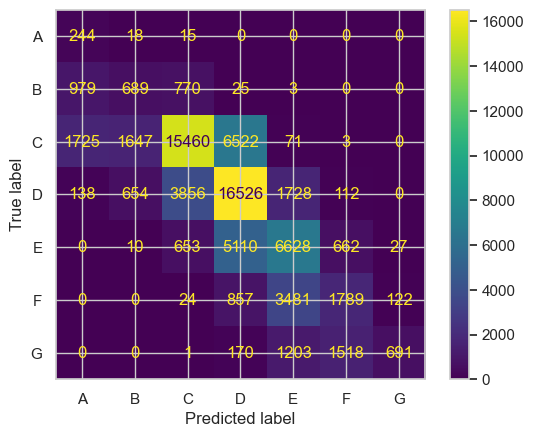

In [335]:
ConfusionMatrixDisplay.from_predictions(df["Etiquette_DPE"], df["etiquette_predite"])

In [336]:
accuracy = accuracy_score(df["Etiquette_DPE"], df["etiquette_predite"], normalize=True)
print("Le taux de prédictions correctes:",accuracy.round(2))

Le taux de prédictions correctes: 0.57


### Régression polynomiale de degré 2

In [337]:

poly_model = make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression())

In [338]:
poly_model.fit(X_train_s,y_train_s)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [339]:
y_pred_test_s = poly_model.predict(X_test_s)
y_pred_train_s = poly_model.predict(X_train_s)

# Évaluation du modèle
mae_train = mean_absolute_error(y_train_s, y_pred_train_s)
mae_test = mean_absolute_error(y_test_s, y_pred_test_s)
score = r2_score(y_train_s, y_pred_train_s)

print("Le score du modèle:", score)
print("L’erreur moyenne absolue pour les données d’entrainement:",mae_train)
print("L’erreur moyenne absolue pour les données du test:",mae_test)

Le score du modèle: 0.8378279848168686
L’erreur moyenne absolue pour les données d’entrainement: 15.234310436900795
L’erreur moyenne absolue pour les données du test: 15.398183427328249


Il n’y a pas un overfitting dans le modèle

In [340]:
predictions = poly_model.predict(X_s)
df['conso_predite_s'] = [predictions[i][0] for i in  range(0,74131)]
df['emission_predite_s'] = [predictions[i][1] for i in  range(0,74131)]

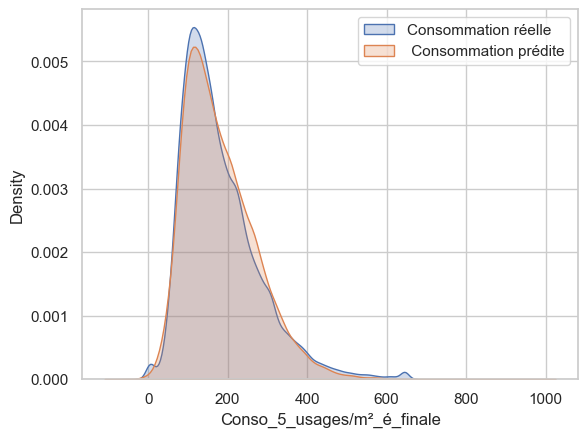

In [341]:
sns.kdeplot(data=df, x='Conso_5_usages/m²_é_finale', fill='Conso_5_usages/m²_é_finale', label="Consommation réelle")
sns.kdeplot(data=df, x="conso_predite_s", fill="conso_predite_s", label=" Consommation prédite")
plt.legend()

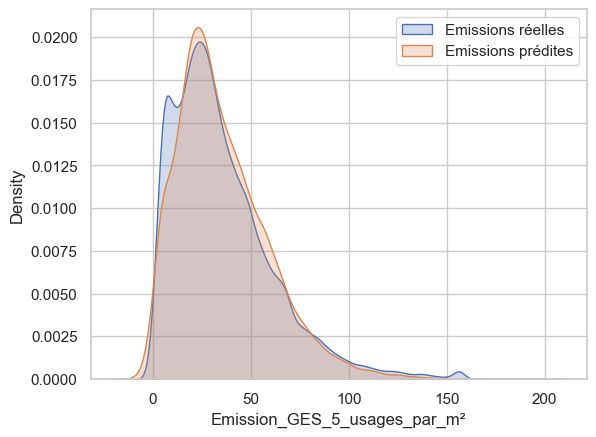

In [342]:
sns.kdeplot(data=df, x='Emission_GES_5_usages_par_m²', fill='Emission_GES_5_usages_par_m²', label="Emissions réelles")
sns.kdeplot(data=df, x="emission_predite_s", fill="emission_predite_s", label="Emissions prédites")
plt.legend()

In [352]:
residus_emission =  df["Emission_GES_5_usages_par_m²"] - df["emission_predite_s"]

residus_consommation =  df["Conso_5_usages/m²_é_finale"] - df["conso_predite_s"]


In [353]:
residus_emission.describe()

count    74131.000000
mean        -0.037282
std         10.781046
min        -94.102826
25%         -4.493764
50%         -0.034309
75%          3.962699
max        138.766727
dtype: float64

In [354]:
residus_consommation.describe()

count    74131.000000
mean        -0.048004
std         38.276702
min       -414.321668
25%        -16.106826
50%         -1.085950
75%         13.644848
max        464.469012
dtype: float64

* Analyse des résidus

Les erreurs de prédiction des deux ont des moyennes proches de 0, avec des écarts-type assez élevés, Cela suggère une variabilité significative dans la performance du modèle. Les valeurs maximales sont importantes, on peut expliquer cela par la présence des outliers dans l’échantillon.

In [346]:
df["etiquette_predite"] = df.apply(remplissage,axis=1)

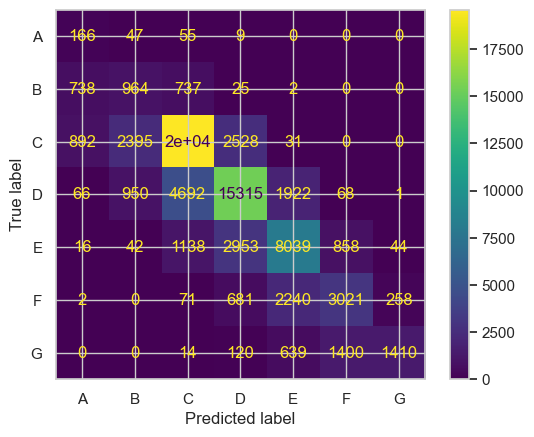

In [347]:
ConfusionMatrixDisplay.from_predictions(df["Etiquette_DPE"], df["etiquette_predite"])

In [348]:
accuracy = accuracy_score(df["Etiquette_DPE"], df["etiquette_predite"], normalize=True)
print("Le taux de prédictions correctes:",accuracy.round(2))

Le taux de prédictions correctes: 0.65


## Autres modèles testés

Nous avons essayé d’autres modèles et d’autres méthodes de préparation de données:

* Suppression des valeurs aberrantes avec la méthode IsolationForest (fonction remove_outliers), le coefficient retenu pour la regression de Lasso est 1, peu de variables explicatives sont retenues, la précision du modèle polynomial augmente (elle vaut 0.99), mais la précision de la classification de l’étiquette DPE diminue, elle passe de 0,68 à 0,62.\
Par rapport aux résidus: l’erreur moyenne pour le volume des émissions est proche de 0, son écart-type est de l’ordre de 13, et les quantiles à 25% et 75% sont respectivement -5,4 et 4,2, les erreurs sont alors regroupées autour de la moyenne 0 avec quelques valeurs extremes ( le max est 308,7 et le min est -433,7)
L’erreur de la prédiction de la consommation est plus dispersée, son écart-type est de 50,1 , sa moyenne est 0,11 et des quartiles sont -19,8 et 14,6.\
La régression polynomiale de degré 2 avec des valeurs aberrantes supprimées par IsolationForest présente l’avantage de minimiser le nombre de variables utilisées pour la prédiction, mais elle affecte légèrement la précision de la classification basée sur les valeurs prédites.

<img src="output.png"  width="600" height="550">




* ElasticNet dans un modèle polynomial de degré 2 : accuracy=0.6 et mauvaise prédiction des valeurs extrêmes.